Predict the axis of a radiology slice or image. Axial, saggital, coronal or X-ray projection image

In [1]:
from keras import layers
from keras import models
from keras import optimizers, callbacks, regularizers
import numpy as np
import tensorflow as tf

print("Tensorflow version {} GPU {}".format(tf.__version__, tf.test.is_gpu_available()))

Using TensorFlow backend.


Tensorflow version 1.13.1 GPU True


In [2]:
import os, shutil
from keras.preprocessing.image import ImageDataGenerator

base_dir = '/home/ktdiedrich/Documents/localData/RadiologyImages/LIDC-IDRI/slice_images'

train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
validation_dir = os.path.join(base_dir, 'validation')

INPUT_SHAPE = (256, 512, 3)
batch_size = 25
permute_range = 0.015
# Traning generator permutes training data to add variety 
train_datagen = ImageDataGenerator(rescale=1.0/255,
    rotation_range = 20,
    width_shift_range=permute_range,
    height_shift_range=permute_range,
    shear_range=permute_range,
    zoom_range=permute_range,
    horizontal_flip=False,
    fill_mode='constant')

test_datagen = ImageDataGenerator(rescale=1.0/255)
train_generator = train_datagen.flow_from_directory(train_dir, target_size=INPUT_SHAPE[0:2], 
                                                    batch_size=batch_size, class_mode='categorical')
test_generator = test_datagen.flow_from_directory(test_dir, target_size=INPUT_SHAPE[0:2],
                                                       batch_size=batch_size, class_mode='categorical')
validation_generator = test_datagen.flow_from_directory(validation_dir, target_size=INPUT_SHAPE[0:2],
                                                       batch_size=batch_size, class_mode='categorical')
class_number = np.unique(train_generator.classes).shape[0]

Found 2329 images belonging to 4 classes.
Found 654 images belonging to 4 classes.
Found 361 images belonging to 4 classes.


In [3]:
def display_sample(generator, title):
    """Display a sample of images from a generator
    """
    i = 0
    rows = 1
    cols = 5
    from keras.preprocessing import image 
    import matplotlib.pyplot as plt

    for data_batch, labels_batch in generator:
        fig = plt.figure(figsize=(20,3))
        fig.tight_layout()
        fig.suptitle("{}, generated batch {} {}".format(title, data_batch.dtype, data_batch.shape))
        int_labels = [ int(np.where(lab > 0)[0]) for lab in labels_batch[0:cols] ]
        for col in range(cols):
            plt.tight_layout()
            plt.subplot(rows, cols, col+1)
            plt.title("label {} {}".format(int_labels[col], data_batch[col].dtype))
            plt.imshow(data_batch[col])
        i += 1
        if i % 4 == 0:
            break
    plt.show()

Display a sample of training data. Label 3 project Xray images are a different intensity scale than the slices 
and often appear to birght to see details. The random ortation caused some smearing of pixel intensities at the edges. 

In [4]:
display_sample(generator=train_generator, title="Training data")
import matplotlib.pyplot as plt
plt.show()

<Figure size 2000x300 with 5 Axes>

<Figure size 2000x300 with 5 Axes>

<Figure size 2000x300 with 5 Axes>

<Figure size 2000x300 with 5 Axes>

In [5]:
def build_model_dropout(class_number, dropout=0.5, input_shape=(150, 150, 3), weight_coef=0.001):
    model = models.Sequential()
    # 32, 3x3 convolution filters
    regl = regularizers.l2(weight_coef)
    model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape, 
                            kernel_regularizer=regl, bias_regularizer=regl, name="Conv2D_input"))
    model.add(layers.MaxPooling2D((2,2), name="MaxPooling_from_input"))
     # 64, 3x3 convolution filters
    model.add(layers.Conv2D(64, (3,3), activation='relu', 
                            kernel_regularizer=regl, bias_regularizer=regl, name="Conv2D_64"))
    model.add(layers.MaxPooling2D((2,2), name="MaxPooling2D_from_C64"))
     # 128, 3x3 convolution filters
    model.add(layers.Conv2D(128, (3,3), activation='relu', 
                            kernel_regularizer=regl, bias_regularizer=regl,
                           name="Conv2D_128"))
    model.add(layers.MaxPooling2D((2,2), name="MaxPooling2D_from_C128"))
    model.add(layers.Flatten(name="Flatten"))
    model.add(layers.Dropout(dropout, name="Dropout"))
    model.add(layers.Dense(512, activation='relu', 
                          kernel_regularizer=regl, bias_regularizer=regl, 
                           name="Dense_512"))
    model.add(layers.Dense(class_number, activation='softmax', name="Dense_softmax"))
    model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['acc'])
    return model


model = build_model_dropout( class_number=class_number, dropout=0.5, input_shape=INPUT_SHAPE)
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2D_input (Conv2D)        (None, 254, 510, 32)      896       
_________________________________________________________________
MaxPooling_from_input (MaxPo (None, 127, 255, 32)      0         
_________________________________________________________________
Conv2D_64 (Conv2D)           (None, 125, 253, 64)      18496     
_________________________________________________________________
MaxPooling2D_from_C64 (MaxPo (None, 62, 126, 64)       0         
_________________________________________________________________
Conv2D_128 (Conv2D)          (None, 60, 124, 128)      73856     
_________________________________________________________________
MaxPooling2D_from_C12

In [6]:
callbacks_list = [
    callbacks.EarlyStopping(monitor='acc', patience=5)    
]

In [7]:
history = model.fit_generator(
    train_generator, steps_per_epoch=90, epochs=60, validation_data=validation_generator, 
    validation_steps=28, callbacks=callbacks_list)


Instructions for updating:
Use tf.cast instead.
Epoch 1/60
90/90 [==============================] - 61s 683ms/step - loss: 1.0412 - acc: 0.9200 - val_loss: 0.5596 - val_acc: 0.9738
Epoch 2/60
90/90 [==============================] - 54s 603ms/step - loss: 0.4388 - acc: 0.9711 - val_loss: 0.3774 - val_acc: 0.9747
Epoch 3/60
90/90 [==============================] - 53s 593ms/step - loss: 0.3452 - acc: 0.9662 - val_loss: 0.3002 - val_acc: 0.9747
Epoch 4/60
90/90 [==============================] - 54s 596ms/step - loss: 0.2799 - acc: 0.9738 - val_loss: 0.2773 - val_acc: 0.9762
Epoch 5/60
90/90 [==============================] - 53s 591ms/step - loss: 0.2696 - acc: 0.9676 - val_loss: 0.2504 - val_acc: 0.9807
Epoch 6/60
90/90 [==============================] - 53s 592ms/step - loss: 0.2440 - acc: 0.9732 - val_loss: 0.2849 - val_acc: 0.9137
Epoch 7/60
90/90 [==============================] - 53s 591ms/step - loss: 0.2144 - acc: 0.9760 - val_loss: 0.2291 - val_acc: 0.9777
Epoch 8/60
90/90 [===

In [8]:
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook
from bokeh.models import Label

def plot_acc_loss(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc)+1)
    
    output_notebook()
    p = figure(plot_width=800, plot_height=400, 
               title='Accuracy', 
               x_axis_label='Epoch', y_axis_label='Accuracy')
    p.circle(epochs, acc, color="firebrick", legend="Training", alpha=.5, size=6)
    p.line(epochs, val_acc, line_color="navy", legend="Validation", alpha=0.5, line_width=2)
    show(p)
    
    p = figure(plot_width=800, plot_height=400, 
               title='Loss', 
               x_axis_label='Epoch', y_axis_label='Loss')
    p.circle(epochs, loss, color="firebrick", legend="Training", alpha=.5, size=6)
    p.line(epochs, val_loss, line_color="navy", legend="Validation", alpha=0.5, line_width=2)
    show(p)
    
    
plot_acc_loss(history=history)

Loading BokehJS ...

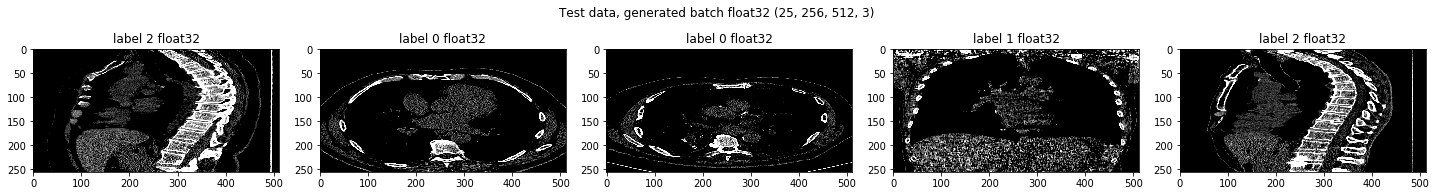

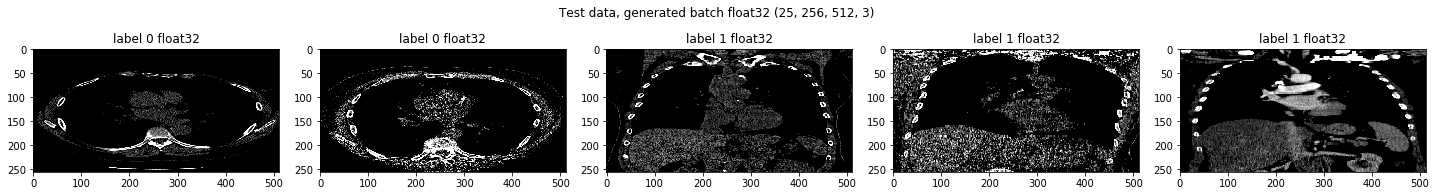

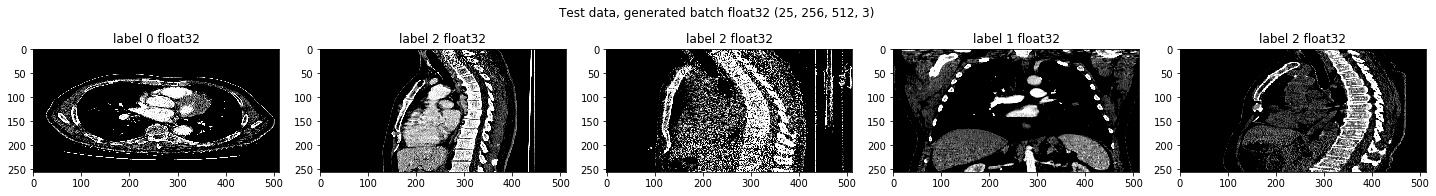

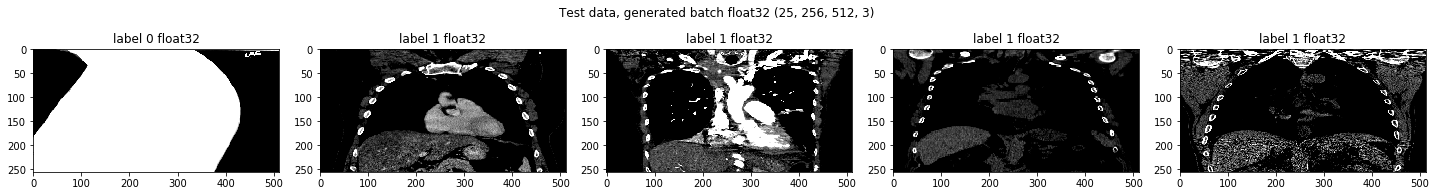

In [9]:
display_sample(generator=test_generator, title="Test data")

In [10]:
evaluation = model.evaluate_generator(test_generator, steps=80)
print("Test loss {:.3}, test accuracy {:.3}".format(evaluation[0], evaluation[1])) 

Test loss 0.172, test accuracy 0.982


In [11]:
model_file = 'radiology_lung_axis.h5'
model.save(model_file)  

In [12]:
reloaded_model = models.load_model(model_file)

In [13]:
re_evaluation = model.evaluate_generator(test_generator, steps=100)
print("Test loss {:.3}, test accuracy {:.3}".format(re_evaluation[0], re_evaluation[1])) 

Test loss 0.177, test accuracy 0.981
